In [104]:
## C_2目标：没得奖的下一届有多大概率得奖
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 模型建立
尝试建立一个神经网络模型学习往年来首次获奖的国家所具有的特征

设$X=[x_1,x_2,x_3]$其中，
| Symbols | meaning                      |
|---------|------------------------------|
| $x_1$   | 国家自参赛以来未有获奖的届数 |
| $x_2$   | 国家拥有的运动员数量         |
| $x_3$   | 此届的平均奖牌数量           |

将$X$作为输入层，设立隐藏层为2层，神经元数量分别为4，3，输出层神经元数量为1表示获奖概率


In [105]:
# 为了能得到样本，我们需要得到当前届每个国家参赛以来的获奖情
# 况以及每一届的运动员数量和当前届的平均项目数量
# 建立样本变量x
x = [[], [], []]  # 后续通过插入进行样本插入
Y = []

In [106]:
def get_ENAS() -> dict:
    programs_data = pd.read_csv("programs_data.csv")
    ENAS = {}
    for y in range(1896, 2025):
        try:
            val = programs_data[str(y)].values
        except:
            continue
        for i in range(len(val)):
            try:
                val[i] = int(val[i])
            except:
                val[i] = 0
        # print(y,val)
        val = np.array(val, dtype="int")
        val = val[val > 0]
        ENAS[y] = val.mean()
    return ENAS


# 得到每一届的项目平均数量
ENAS = get_ENAS()
ENAS

{1896: 8.23076923076923,
 1900: 9.44,
 1904: 10.666666666666666,
 1908: 9.535714285714286,
 1912: 11.238095238095237,
 1920: 11.34375,
 1924: 11.23076923076923,
 1928: 10.956521739130435,
 1932: 11.652173913043478,
 1936: 10.785714285714286,
 1948: 12.0,
 1952: 13.0,
 1956: 13.153846153846153,
 1960: 13.076923076923077,
 1964: 13.214285714285714,
 1968: 14.296296296296296,
 1972: 14.161290322580646,
 1976: 14.8,
 1980: 15.133333333333333,
 1984: 15.375,
 1988: 15.529411764705882,
 1992: 15.486486486486486,
 1996: 15.1,
 2000: 15.511627906976743,
 2004: 15.55813953488372,
 2008: 14.955555555555556,
 2012: 15.581395348837209,
 2016: 15.155555555555555,
 2020: 14.358490566037736,
 2024: 14.470588235294118}

In [107]:
# 导入奖牌榜
counts_data = pd.read_csv("counts_data.csv")
# 导入运动员榜
athletes_data = pd.read_csv("athletes_data.csv")
# 这两个榜单都是从data.ipynb运行导出的csv文件

In [108]:
# 获得一共有哪些国家参加过比赛
NOC_list = set(list(athletes_data["NOC"]))
# 获得最后一场比赛依然没有获奖的国家以及它最后一场比赛的三个参数
noc_o_list = dict()
# 对于每一个国家，获得它自参赛以来的每一届获奖数量
counts_year_g = counts_data.groupby("Year")
athletes_noc_g = athletes_data.groupby("NOC")
for noc in NOC_list:
    # 得到这个国家参加过哪届比赛
    athletes_noc_data = athletes_noc_g.get_group(noc)
    p_year = set(list(athletes_noc_data["Year"]))
    p_year = list(p_year)
    p_year = sorted(p_year)
    # 设立奖牌列表
    medalcount_list = []
    # 设立运动员数量列表
    athletes_num_list = []
    # 遍历得到这个国家参赛的每一届获奖数据以及每一年的远动员数量
    for p in p_year:
        if p == 1906:
            continue
        # 得到p年的获奖榜单
        tem = counts_year_g.get_group(p)
        # 得到p年的运动员名单
        p_athletes = athletes_noc_data.groupby("Year")
        p_athletes = p_athletes.get_group(p)
        # 查找是否有noc这个国家，有则插入Toal否则0
        _noc_list = tem["NOC"].values
        if noc not in _noc_list:
            medalcount_list.append(0)
        else:
            medalcount_list.append(tem["Total"][tem["NOC"] == noc].values[0])
        # 得到运动员的数量
        athletes_num = len(set(list(p_athletes["Name"])))
        athletes_num_list.append(athletes_num)
    # 判断这个国家是否能成为样本
    # 条件：首次比赛不能拿奖
    try:
        if medalcount_list[0] != 0:
            continue
    except:
        print(f"appear error country:{noc}")
        print(f"medalcount_list={medalcount_list}")
        print(f"p_year={p_year}")
        continue
    # 记录当前未拿奖的次数x_1
    x_1 = [1]
    try:
        if medalcount_list[1] == 0:
            y = [0]
        else:
            y = [1]
    except:
        pass
    for num in medalcount_list[2:]:
        if num == 0:
            x_1.append(x_1[-1] + 1)
            y.append(0)
        else:
            x_1.append(x_1[-1] + 1)
            y.append(1)
            break
    # 记录前len(x_1)届的运动员数量
    x_2 = athletes_num_list[0 : len(x_1)]
    x_2 = np.array(x_2)
    # 获得前len(x_1)届的平均运动项目数量
    x_3 = [0.0] * len(x_1)
    for i in range(len(x_1)):
        try:
            x_3[i] = ENAS[p_year[i]]
        except:
            x_3[i] = 10
    # 判断是不是从未获得过奖项
    if y[-1] == 0:
        noc_o_list[noc] = [x_1[-1], x_2[-1], x_3[-1]]
    # print(f"x_1={x_1},\nx_2={x_2},\nx_3={x_3}")
    for i in range(len(x_1)):
        try:
            x[0].append(x_1[i])
            x[1].append(x_2[i])
            x[2].append(x_3[i])
            Y.append(y[i])
        except:
            print(f"i={i}")

appear error country:CRT
medalcount_list=[]
p_year=[1906]


In [109]:
x = np.array(x)
Y = np.array(Y)
x = x.T
print(f"x.shape={x.shape},Y.shape={Y.shape}")

x.shape=(1341, 3),Y.shape=(1341,)


In [ ]:
# 接下来进行学习：
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# 构建模型
model = Sequential(
    [
        Dense(4, input_dim=3, activation="relu"),  # 输入层和第1隐藏层
        Dense(3, activation="relu"),  # 第2隐藏层
        Dense(1, activation="sigmoid"),  # 输出层，用于概率预测
    ]
)

# 编译模型
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]  # 二分类问题
)

# 模型概览
model.summary()

X_train = x
y_train = Y
# 训练模型
# epochs模型迭代次数
# batch_size样本分组16组
# validation_split测试训练集合比
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

c:\Users\22230\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 4)                 │         16 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_16 (Dense)                │ (None, 3)                 │         15 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_17 (Dense)                │ (None, 1)                 │          4 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1760 - loss: 2.2398 - val_accuracy: 0.5537 - val_loss: 0.6939
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6876 - loss: 0.6100 - val_accuracy: 0.9072 - val_loss: 0.5294
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9185 - loss: 0.4230 - val_accuracy: 0.9072 - val_loss: 0.4707
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.9274 - loss: 0.3788 - val_accuracy: 0.9072 - val_loss: 0.4207
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.9010 - loss: 0.3641 - val_accuracy: 0.9072 - val_loss: 0.3944
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.9172 - loss: 0.3127 - val_accuracy: 0.9072 - val_loss: 0.3688
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.9108 - loss: 0.3137 - val_accuracy: 0.9072 - val_loss: 0.3619
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9373 - loss: 0.2549 - val_accuracy: 0.

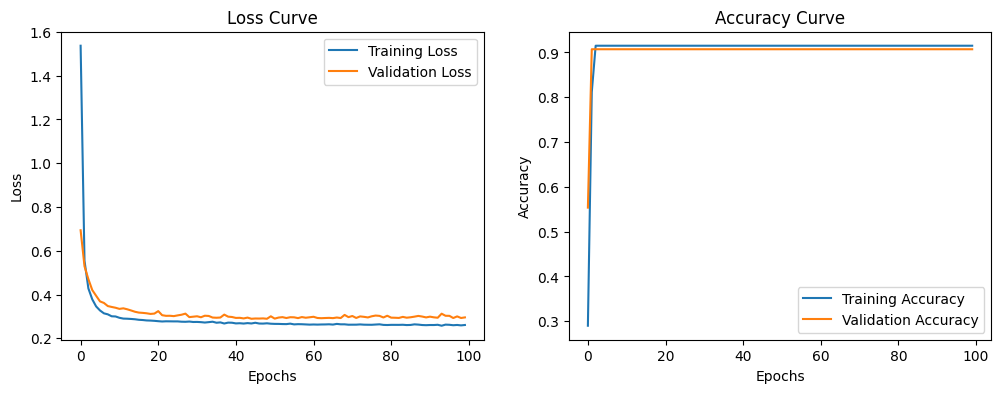

In [ ]:
# 提取历史记录
loss = history.history["loss"]  # 训练损失
val_loss = history.history["val_loss"]  # 验证损失
accuracy = history.history["accuracy"]  # 训练准确率
val_accuracy = history.history["val_accuracy"]  # 验证准确率

# 绘制学习曲线：损失
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# 绘制学习曲线：准确率
plt.subplot(1, 2, 2)
plt.plot(accuracy, label="Training Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
# 进行2028年的预测
# 得到如今依旧没有获奖的国家
# print(noc_o_list)
# 预测每个国家的拿奖概率
noc_o_p = dict()
for i in noc_o_list.keys():
    # print(noc_o_list[i])
    x = noc_o_list[i]
    x = np.array(x)
    x = x.reshape((1, 3))
    ans = model.predict(x)
    # 百分化
    noc_o_p[i] = ans[0][0] * 100
noc_o_p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

{'OMA': 3.7762634456157684,
 'UAR': 40.75018763542175,
 'AND': 5.547330155968666,
 'TGA': 4.228144139051437,
 'SEY': 3.946196660399437,
 'ANZ': 40.75018763542175,
 'GBS': 5.140040814876556,
 'KIR': 5.981724709272385,
 'MLI': 3.625454753637314,
 'SOM': 5.671484395861626,
 'VNM': 6.56139999628067,
 'TUV': 6.001482531428337,
 'ANG': 10.7850581407547,
 'LIB': 2.5274790823459625,
 'COK': 4.724777117371559,
 'RWA': 3.946196660399437,
 'LAO': 3.7762634456157684,
 'NIG': 3.238867223262787,
 'EOR': 25.71185827255249,
 'DJI': 4.117594659328461,
 'ERI': 7.411003857851028,
 'MTN': 5.671484395861626,
 'WIF': 18.102876842021942,
 'BUR': 4.529290273785591,
 'CHA': 4.489382728934288,
 'SSD': 9.016522020101547,
 'PLW': 5.360407754778862,
 'YEM': 4.928262904286385,
 'BEN': 3.623693808913231,
 'MAL': 31.681248545646667,
 'LIE': 2.599206753075123,
 'MDV': 4.117594659328461,
 'MON': 1.8578523769974709,
 'BOL': 2.922695130109787,
 'HON': 13.684584200382233,
 'BRN': 11.775389313697815,
 'MNE': 10.86469516158

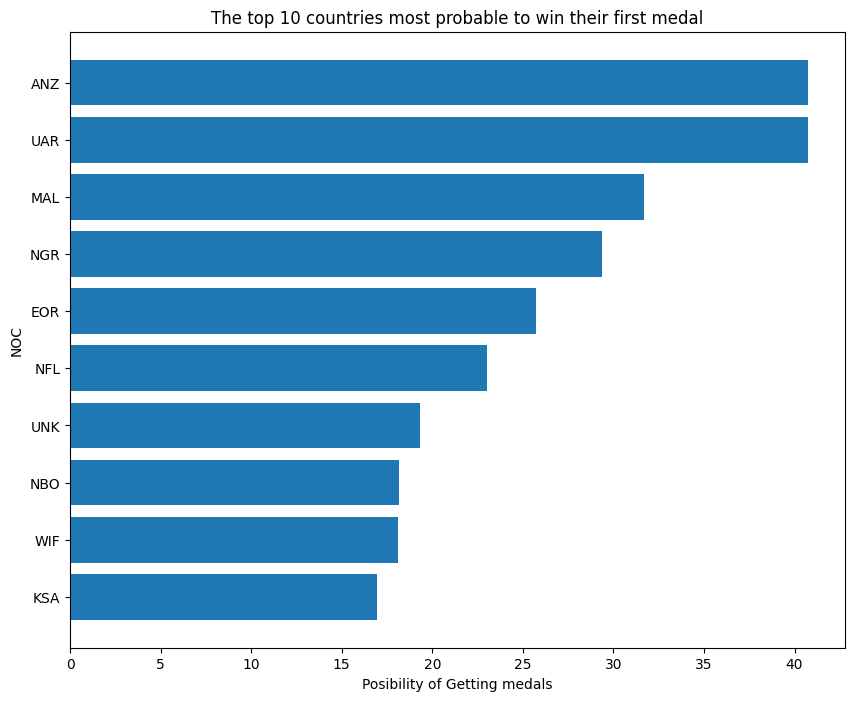

In [144]:
o_p = [noc_o_p[i] for i in noc_o_p.keys()]
o_p = np.array(o_p)
noc_o = list(noc_o_list.keys())
noc_o = np.array(noc_o)
indices = np.argsort(o_p)
show_indices = indices[::-1][0:10]
try:
    plt.figure(figsize=(10, 8))
    plt.title("The top 10 countries most probable to win their first medal")
    plt.barh(noc_o[show_indices], [noc_o_p[i] for i in noc_o[show_indices]])
    plt.gca().invert_yaxis()
    plt.ylabel("NOC")
    plt.xlabel("Posibility of Getting medals")
    plt.show()

except:
    print(show_indices)
    print(noc_o[show_indices])